# Kunskapskontroll – Koduppgifter


Det här dokumentet inehåller endast koduppgifter.
Fakta/resonemangsfrågor finns i `kunskapskontroll_fragor.ipynb`.
Streamlit-applikationen finns i `streamlit_app.py`.

## Bibliotek


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras_tuner as kt
import os

from pathlib import Path

from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import keras

from sklearn.datasets import fetch_openml

/Users/user/mai24ma/AI_theory_2/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


(10000, 784)
(10000,)


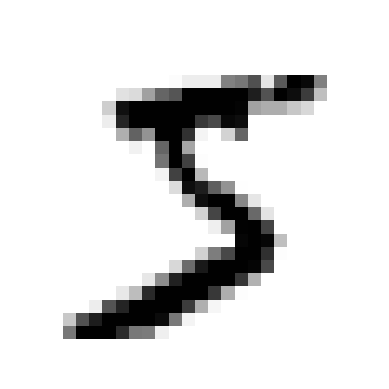

Label: 5


In [2]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"][:10000]  
y = mnist["target"][:10000].astype(np.uint8) 

print(X.shape)
print(y.shape)

some_digit = X[0]  # fetches the first image
some_digit_image = some_digit.reshape(28, 28)  
plt.imshow(some_digit_image, cmap=mpl.cm.binary) 
plt.axis("off")
plt.show()
print("Label:", y[0])

# Kapitel 7 – ANN (Artificial Neural Networks)

### Koduppgift 10a


In [3]:
# Train ANN model on MNIST dataset

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() 
x_train = x_train / 255.0 
x_test = x_test / 255.0

model = keras.Sequential([ 
    keras.layers.Flatten(input_shape=(28, 28)), 
    keras.layers.Dense(128, activation="relu"), 
    keras.layers.Dense(10, activation="softmax"), 
])

model.compile( 
    optimizer="adam", 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"], 
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=2, 
    restore_best_weights=True, 
 )

model.fit( 
    x_train, 
    y_train, 
    epochs=3, 
    validation_split=0.1, 
    callbacks=[early_stopping],
    verbose=2,
 )
print("Test accuracy:", model.evaluate(x_test, y_test, verbose=0)[1])

Epoch 1/3


/Users/user/mai24ma/AI_theory_2/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1688/1688 - 3s - 2ms/step - accuracy: 0.9216 - loss: 0.2764 - val_accuracy: 0.9645 - val_loss: 0.1214
Epoch 2/3
1688/1688 - 2s - 1ms/step - accuracy: 0.9649 - loss: 0.1174 - val_accuracy: 0.9717 - val_loss: 0.0934
Epoch 3/3
1688/1688 - 2s - 1ms/step - accuracy: 0.9760 - loss: 0.0796 - val_accuracy: 0.9763 - val_loss: 0.0809
Test accuracy: 0.9743000268936157


### Koduppgift 10b


In [4]:
# Keras Tuner

def build_model(hp): 
    units = hp.Choice("units", [64, 128, 256]) 
    lr = hp.Choice("lr", [1e-2, 1e-3]) 

    m = keras.Sequential([ 
        keras.layers.Flatten(input_shape=(28, 28)), 
        keras.layers.Dense(units, activation="relu"), 
        keras.layers.Dense(10, activation="softmax"), 
    ])
    m.compile( 
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        loss="sparse_categorical_crossentropy", 
        metrics=["accuracy"], 
    )
    return m

early_stopping = keras.callbacks.EarlyStopping( 
    monitor="val_accuracy", 
    patience=2, 
    mode="max",
    restore_best_weights=True, 
    )

tuner = kt.RandomSearch( 
    build_model, 
    objective="val_accuracy", 
    max_trials=5, 
    directory="kt_logs",
    project_name="koduppgift_10b",
    overwrite=True, 
 )

tuner.search( 
    x_train, 
    y_train,
    epochs=3,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=2,
 )

best_model = tuner.get_best_models(1)[0] 
print("Tuned test accuracy:", best_model.evaluate(x_test, y_test, verbose=0)[1]) 

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.9621666669845581

Best val_accuracy So Far: 0.9726666808128357
Total elapsed time: 00h 00m 35s


/Users/user/mai24ma/AI_theory_2/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Tuned test accuracy: 0.9679999947547913


## Kapitel 8 – CNN (Convolutional Neural Networks)

### Koduppgift 8a

In [5]:
# CNN on CIFAR-100

LIMIT = 10000
EPOCHS = 50
BATCH_SIZE = 128 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine") 
if LIMIT is not None: 
    x_train, y_train = x_train[:LIMIT], y_train[:LIMIT]

x_train = x_train.astype("float32") / 255.0 
x_test  = x_test.astype("float32") / 255.0
y_train = y_train.squeeze() 
y_test  = y_test.squeeze()

model_a = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=(32, 32, 3)), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation="relu"), 
    tf.keras.layers.Dense(100, activation="softmax"), 
])

model_a.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]) 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=2, mode="max", restore_best_weights=True 
 )

model_a.fit(x_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping], verbose=2) 

acc_a = model_a.evaluate(x_test, y_test, verbose=0)[1] 
print("(a) Test accuracy:", acc_a) 

results = {"a_cnn": float(acc_a)}

Epoch 1/50


/Users/user/mai24ma/AI_theory_2/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 - 3s - 46ms/step - accuracy: 0.0279 - loss: 4.4870 - val_accuracy: 0.0505 - val_loss: 4.2777
Epoch 2/50
63/63 - 2s - 35ms/step - accuracy: 0.0768 - loss: 4.0870 - val_accuracy: 0.1020 - val_loss: 3.9403
Epoch 3/50
63/63 - 2s - 36ms/step - accuracy: 0.1249 - loss: 3.7677 - val_accuracy: 0.1215 - val_loss: 3.7749
Epoch 4/50
63/63 - 2s - 37ms/step - accuracy: 0.1731 - loss: 3.5040 - val_accuracy: 0.1360 - val_loss: 3.7155
Epoch 5/50
63/63 - 2s - 38ms/step - accuracy: 0.2091 - loss: 3.2870 - val_accuracy: 0.1795 - val_loss: 3.5171
Epoch 6/50
63/63 - 2s - 37ms/step - accuracy: 0.2469 - loss: 3.0794 - val_accuracy: 0.1905 - val_loss: 3.4949
Epoch 7/50
63/63 - 2s - 37ms/step - accuracy: 0.2887 - loss: 2.8893 - val_accuracy: 0.2095 - val_loss: 3.4198
Epoch 8/50
63/63 - 2s - 36ms/step - accuracy: 0.3330 - loss: 2.6877 - val_accuracy: 0.2225 - val_loss: 3.3207
Epoch 9/50
63/63 - 2s - 37ms/step - accuracy: 0.3635 - loss: 2.5209 - val_accuracy: 0.2145 - val_loss: 3.3598
Epoch 10/50
63/63 - 2

### Koduppgft 8b

In [6]:
# KerasTuner (CIFAR-100) - Hyperparameter tuning

def build_model_b(hp):
    lr = hp.Choice("lr", [1e-3, 3e-4, 1e-4])               
    drop = hp.Choice("dropout", [0.0, 0.1, 0.2])           
    f1 = hp.Choice("filters_1", [32, 48, 64])             
    f2 = hp.Choice("filters_2", [64, 96, 128])               
    dense_units = hp.Choice("dense_units", [128, 256, 512])  

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(32, 32, 3)),

        tf.keras.layers.Conv2D(f1, 3, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(f2, 3, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D(),

        # Head
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(drop),
        tf.keras.layers.Dense(dense_units, activation="relu"),
        tf.keras.layers.Dropout(drop),
        tf.keras.layers.Dense(100, activation="softmax"),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Tuner setup
tuner = kt.RandomSearch(
    hypermodel=build_model_b,
    objective="val_accuracy",
    max_trials=3, # körde den med 12 trials via Google Colab men här sätter jag till 3 för att datorn inte ska brinna upp.
    directory="kt_logs",
    project_name="koduppgift_8b_cifar100",
    overwrite=False,
)

early_stop_tuner = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    mode="max",
    restore_best_weights=True,
)

tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=128,
    callbacks=[early_stop_tuner],
    verbose=2,
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

best_model_b = tuner.get_best_models(1)[0]
test_loss, test_acc = best_model_b.evaluate(x_test, y_test, verbose=0)
print("(b) Test accuracy (tuned):", test_acc)

results["b_tuned"] = float(test_acc)
print("Jämförelse:", results)

Trial 3 Complete [00h 02m 09s]
val_accuracy: 0.15299999713897705

Best val_accuracy So Far: 0.16899999976158142
Total elapsed time: 00h 06m 02s
Best hyperparameters: {'lr': 0.0001, 'dropout': 0.0, 'filters_1': 48, 'filters_2': 128, 'dense_units': 512}


/Users/user/mai24ma/AI_theory_2/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(b) Test accuracy (tuned): 0.15800000727176666
Jämförelse: {'a_cnn': 0.23589999973773956, 'b_tuned': 0.15800000727176666}


### Koduppgfit 8c

In [7]:
# Transfer learning (CIFAR-100 -> MobileNetV2)

IMG_SIZE = 160 
EPOCHS = 20

base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
 )
base.trainable = False  

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
x = tf.keras.layers.Rescaling(2.0, offset=-1.0)(x) 
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(100, activation="softmax")(x)
model_c = tf.keras.Model(inputs, outputs)

model_c.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
 )

model_c.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=2,
 )

acc_c = model_c.evaluate(x_test, y_test, verbose=0)[1]
print("(c) Test accuracy (transfer learning):", acc_c)

results["c_transfer_learning"] = float(acc_c)
print("\n=== Slutlig jämförelse ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Epoch 1/20
63/63 - 35s - 554ms/step - accuracy: 0.2064 - loss: 3.5988 - val_accuracy: 0.4465 - val_loss: 2.1791
Epoch 2/20
63/63 - 33s - 525ms/step - accuracy: 0.5234 - loss: 1.8367 - val_accuracy: 0.5275 - val_loss: 1.7180
Epoch 3/20
63/63 - 31s - 493ms/step - accuracy: 0.6152 - loss: 1.4021 - val_accuracy: 0.5470 - val_loss: 1.6086
Epoch 4/20
63/63 - 31s - 498ms/step - accuracy: 0.6749 - loss: 1.1734 - val_accuracy: 0.5880 - val_loss: 1.5144
Epoch 5/20
63/63 - 32s - 507ms/step - accuracy: 0.7209 - loss: 1.0002 - val_accuracy: 0.5845 - val_loss: 1.4689
Epoch 6/20
63/63 - 30s - 479ms/step - accuracy: 0.7592 - loss: 0.8701 - val_accuracy: 0.5860 - val_loss: 1.4409
(c) Test accuracy (transfer learning): 0.5679000020027161

=== Slutlig jämförelse ===
a_cnn: 0.2359
b_tuned: 0.1580
c_transfer_learning: 0.5679


### Koduppgift 9a

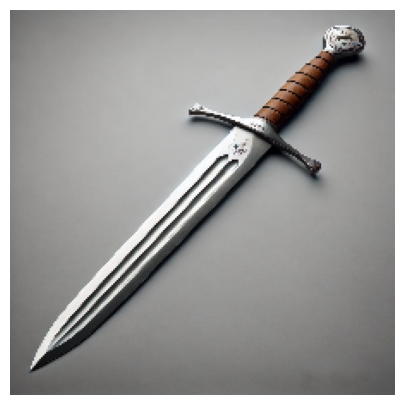

Top-prediktioner:
- letter_opener              0.671
- scabbard                   0.291
- fountain_pen               0.003
- nail                       0.002
- ballpoint                  0.002


In [8]:
# Predict with MobileNetV2

model = MobileNetV2(weights="imagenet") 

def show_prediction(image_path: str | os.PathLike, k: int = 5): 
    path = Path(image_path)

    img = tf.keras.utils.load_img(path, target_size=(224, 224)) 
    arr = tf.keras.utils.img_to_array(img) 
    arr = preprocess_input(np.expand_dims(arr, axis=0)) 

    preds = model(tf.convert_to_tensor(arr), training=False).numpy() 
    top = decode_predictions(preds, top=k)[0] 

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off") 
    plt.show()

    print("Top-prediktioner:")
    for (_, label, prob) in top: 
        print(f"- {label:25s}  {prob:.3f}") 

show_prediction("/Users/user/mai24ma/AI_theory_2/kunskapskontroll/images/sting.png")


### Lite kuriosa. "Svärdet" på bilden är från The Hobbit. Dvärgarna kallar det dock för en "letter opener" i en av filmerna. Är man lite Tolkien-nörd som jag så va det ganska kul. 

### Kodupggfit 9b) Streamlit-app

Streamlit app i separat fil - `chapter_8_assignment_9b` Valde MobileNetV2. Kollade på ResNet50, EfficientNetB0 och DenseNet121 också men MobileNetV2 var snabbast och gav ändå bra resultat.

# Kapitel 10 – Chattbottar

- **Koduppgift 8:** Uppgfiten finns i filen `chapter_10_assignment_8.ipynb`